In [48]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score, classification_report, accuracy_score
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_predict, cross_val_score
from sklearn.ensemble import VotingClassifier
from sklearn.feature_selection import mutual_info_regression,mutual_info_classif, SelectKBest
from sklearn.preprocessing import PolynomialFeatures
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.svm import SVC
import scikitplot as skplt
import warnings

warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [47]:
!pip install scikit-plot --quiet

In [15]:
X = pd.read_csv('data/train.csv', index_col='id')
X_test = pd.read_csv('data/test.csv', index_col='id')
#X = pd.read_csv('/kaggle/input/playground-series-s3e23/train.csv', index_col='id')
#X_test = pd.read_csv('/kaggle/input/playground-series-s3e23/test.csv', index_col='id')
y = X.pop('defects')

In [4]:
X.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
id,,,,,,,,,,,,,,,,,,,,,
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,302.71,17,1,1,0,16.0,9.0,38.0,22.0,5.0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,52.04,11,0,1,0,11.0,11.0,18.0,14.0,3.0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,97.45,8,0,1,0,12.0,11.0,28.0,17.0,3.0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,26.31,4,0,2,0,8.0,6.0,16.0,7.0,1.0
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,20.31,7,0,2,0,7.0,6.0,10.0,10.0,3.0


## Data Checking

In [5]:
print(f"Number of nan values in train data: {X.isnull().sum().sum()}")
print(f"Number of nan values in test data: {X_test.isnull().sum().sum()}")

Number of nan values in train data: 0
Number of nan values in test data: 0


Good news, as we see we have no nan values in all the datasets, so we don't need to infer any of these.

## Feature Selection

We want to see the relationship between our features and the defect field. Ideally we will drop the features that have no influence on 
the defect field.

For these, we use the Mutual Information score between each feature and defect.

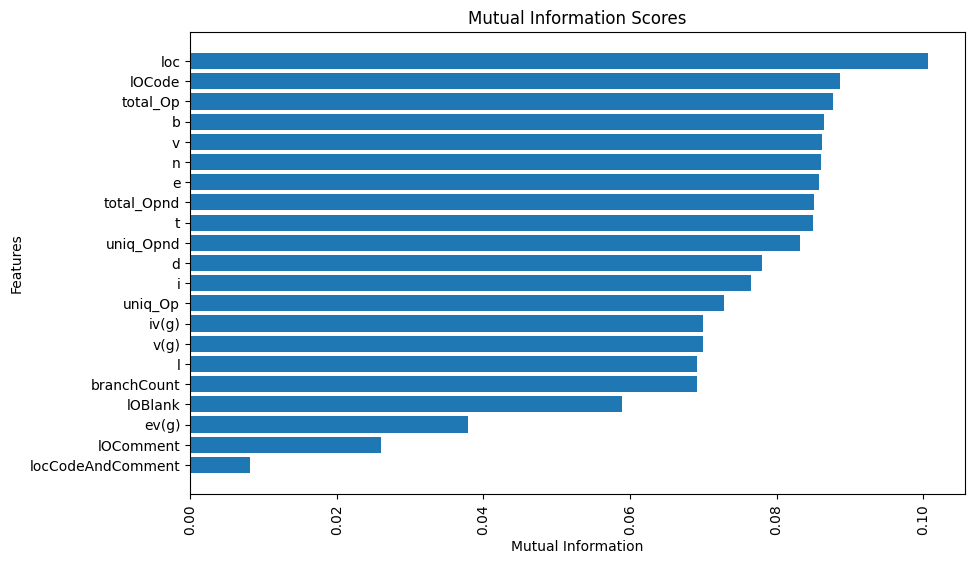

In [6]:
mutual_info = mutual_info_classif(X, y)
mi_scores = pd.DataFrame(mutual_info, index=X.columns, columns=["Mutual Information"])
mi_scores = mi_scores.sort_values(by="Mutual Information", ascending=True)
plt.figure(figsize=(10, 6))
plt.barh(mi_scores.index, mi_scores["Mutual Information"])
plt.xticks(rotation=90)
plt.xlabel('Mutual Information')
plt.ylabel('Features')
plt.title('Mutual Information Scores')
plt.show()

As we can see, each columns has a quit low Mutual Information score (maximum is 1, meaning a strong relationship between the feature and the outcome).
In our case, we can try to remove the loCodeAndComment the features, but we might keep all the others.

In [7]:
X.drop(columns=['locCodeAndComment'], inplace=True)
X_test.drop(columns=['locCodeAndComment'], inplace=True)

## Feature Engineering

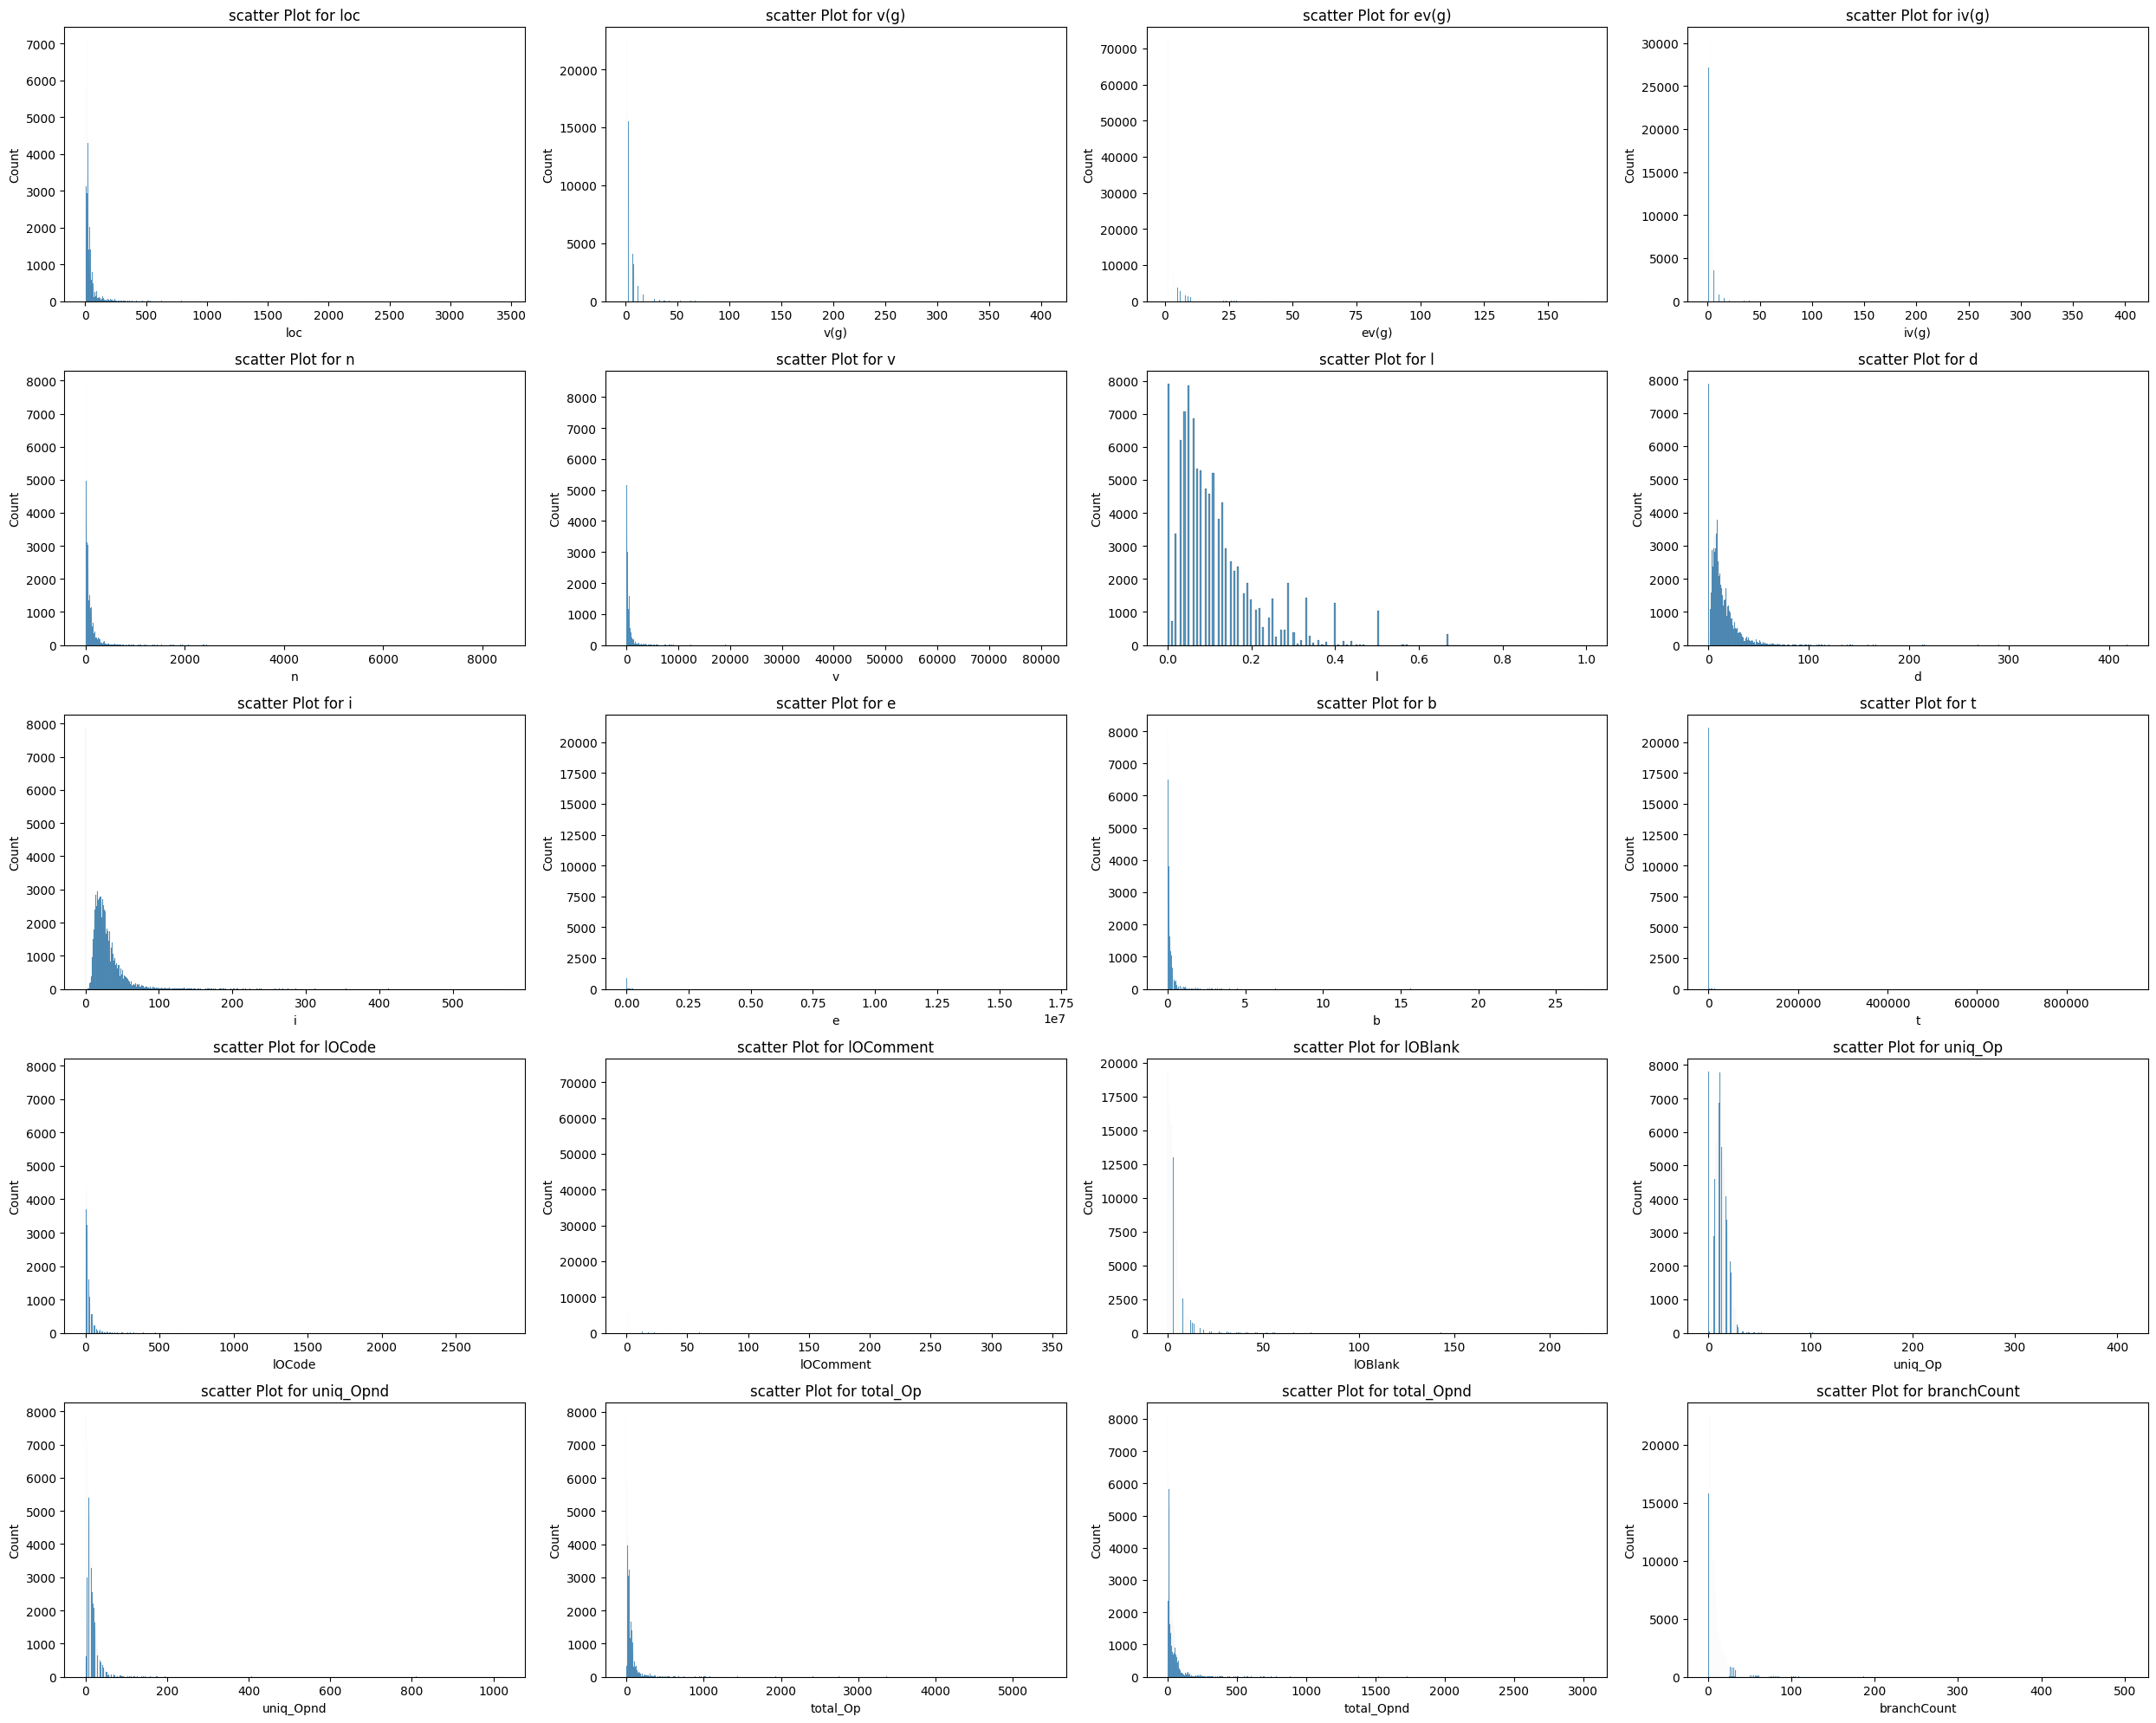

In [7]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
# Flatten the axes array for easier iteration
axes = axes.flatten()
for i, col in enumerate(X.columns):
    #sns.scatterplot(x=y, y=X[col], ax=axes[i])
    sns.histplot(x=X[col], ax=axes[i])
    axes[i].set_title(f"scatter Plot for {col}")
plt.tight_layout()
# Show the plots
plt.show()

As we see, most of our data is left-squewed, so it might be a good idea to apply a log-transformation to each of the column. This can 
allows our model to better discriminate the different values of each feature.

In [60]:
# log value of every column
X_log = np.log(X)
X_test_log = np.log(X_test)
# replace -inf with 0 again
X_log = X_log.replace(-np.inf, 0)
X_test_log = X_test_log.replace(-np.inf, 0)
X_log.head()

,loc,v(g),ev(g),iv(g),n,v,l,d,i,e,...,t,lOCode,lOComment,lOBlank,locCodeAndComment,uniq_Op,uniq_Opnd,total_Op,total_Opnd,branchCount
id,,,,,,,,,,,,,,,,,,,,,
0,3.091042,1.098612,0.0,0.693147,4.094345,5.629885,-2.813411,2.973487,2.656757,8.603149,...,5.712775,2.833213,0.0,0.000000,0.0,2.772589,2.197225,3.637586,3.091042,1.609438
1,2.639057,0.693147,0.0,0.693147,3.465736,5.019066,-1.966113,1.945910,3.049747,6.842374,...,3.952013,2.397895,0.0,0.000000,0.0,2.397895,2.397895,2.890372,2.639057,1.098612
2,2.397895,0.693147,0.0,0.693147,3.806662,5.286498,-2.207275,2.085672,3.125005,7.469660,...,4.579339,2.079442,0.0,0.000000,0.0,2.484907,2.397895,3.332205,2.833213,1.098612
3,2.079442,0.000000,0.0,0.000000,3.135494,4.543401,-1.660731,1.658228,2.882564,6.160490,...,3.269949,1.386294,0.0,0.693147,0.0,2.079442,1.791759,2.772589,1.945910,0.000000
4,2.397895,0.693147,0.0,0.693147,2.833213,4.109890,-1.714798,1.728109,2.520917,5.901731,...,3.011113,1.945910,0.0,0.693147,0.0,1.945910,1.791759,2.302585,2.302585,1.098612


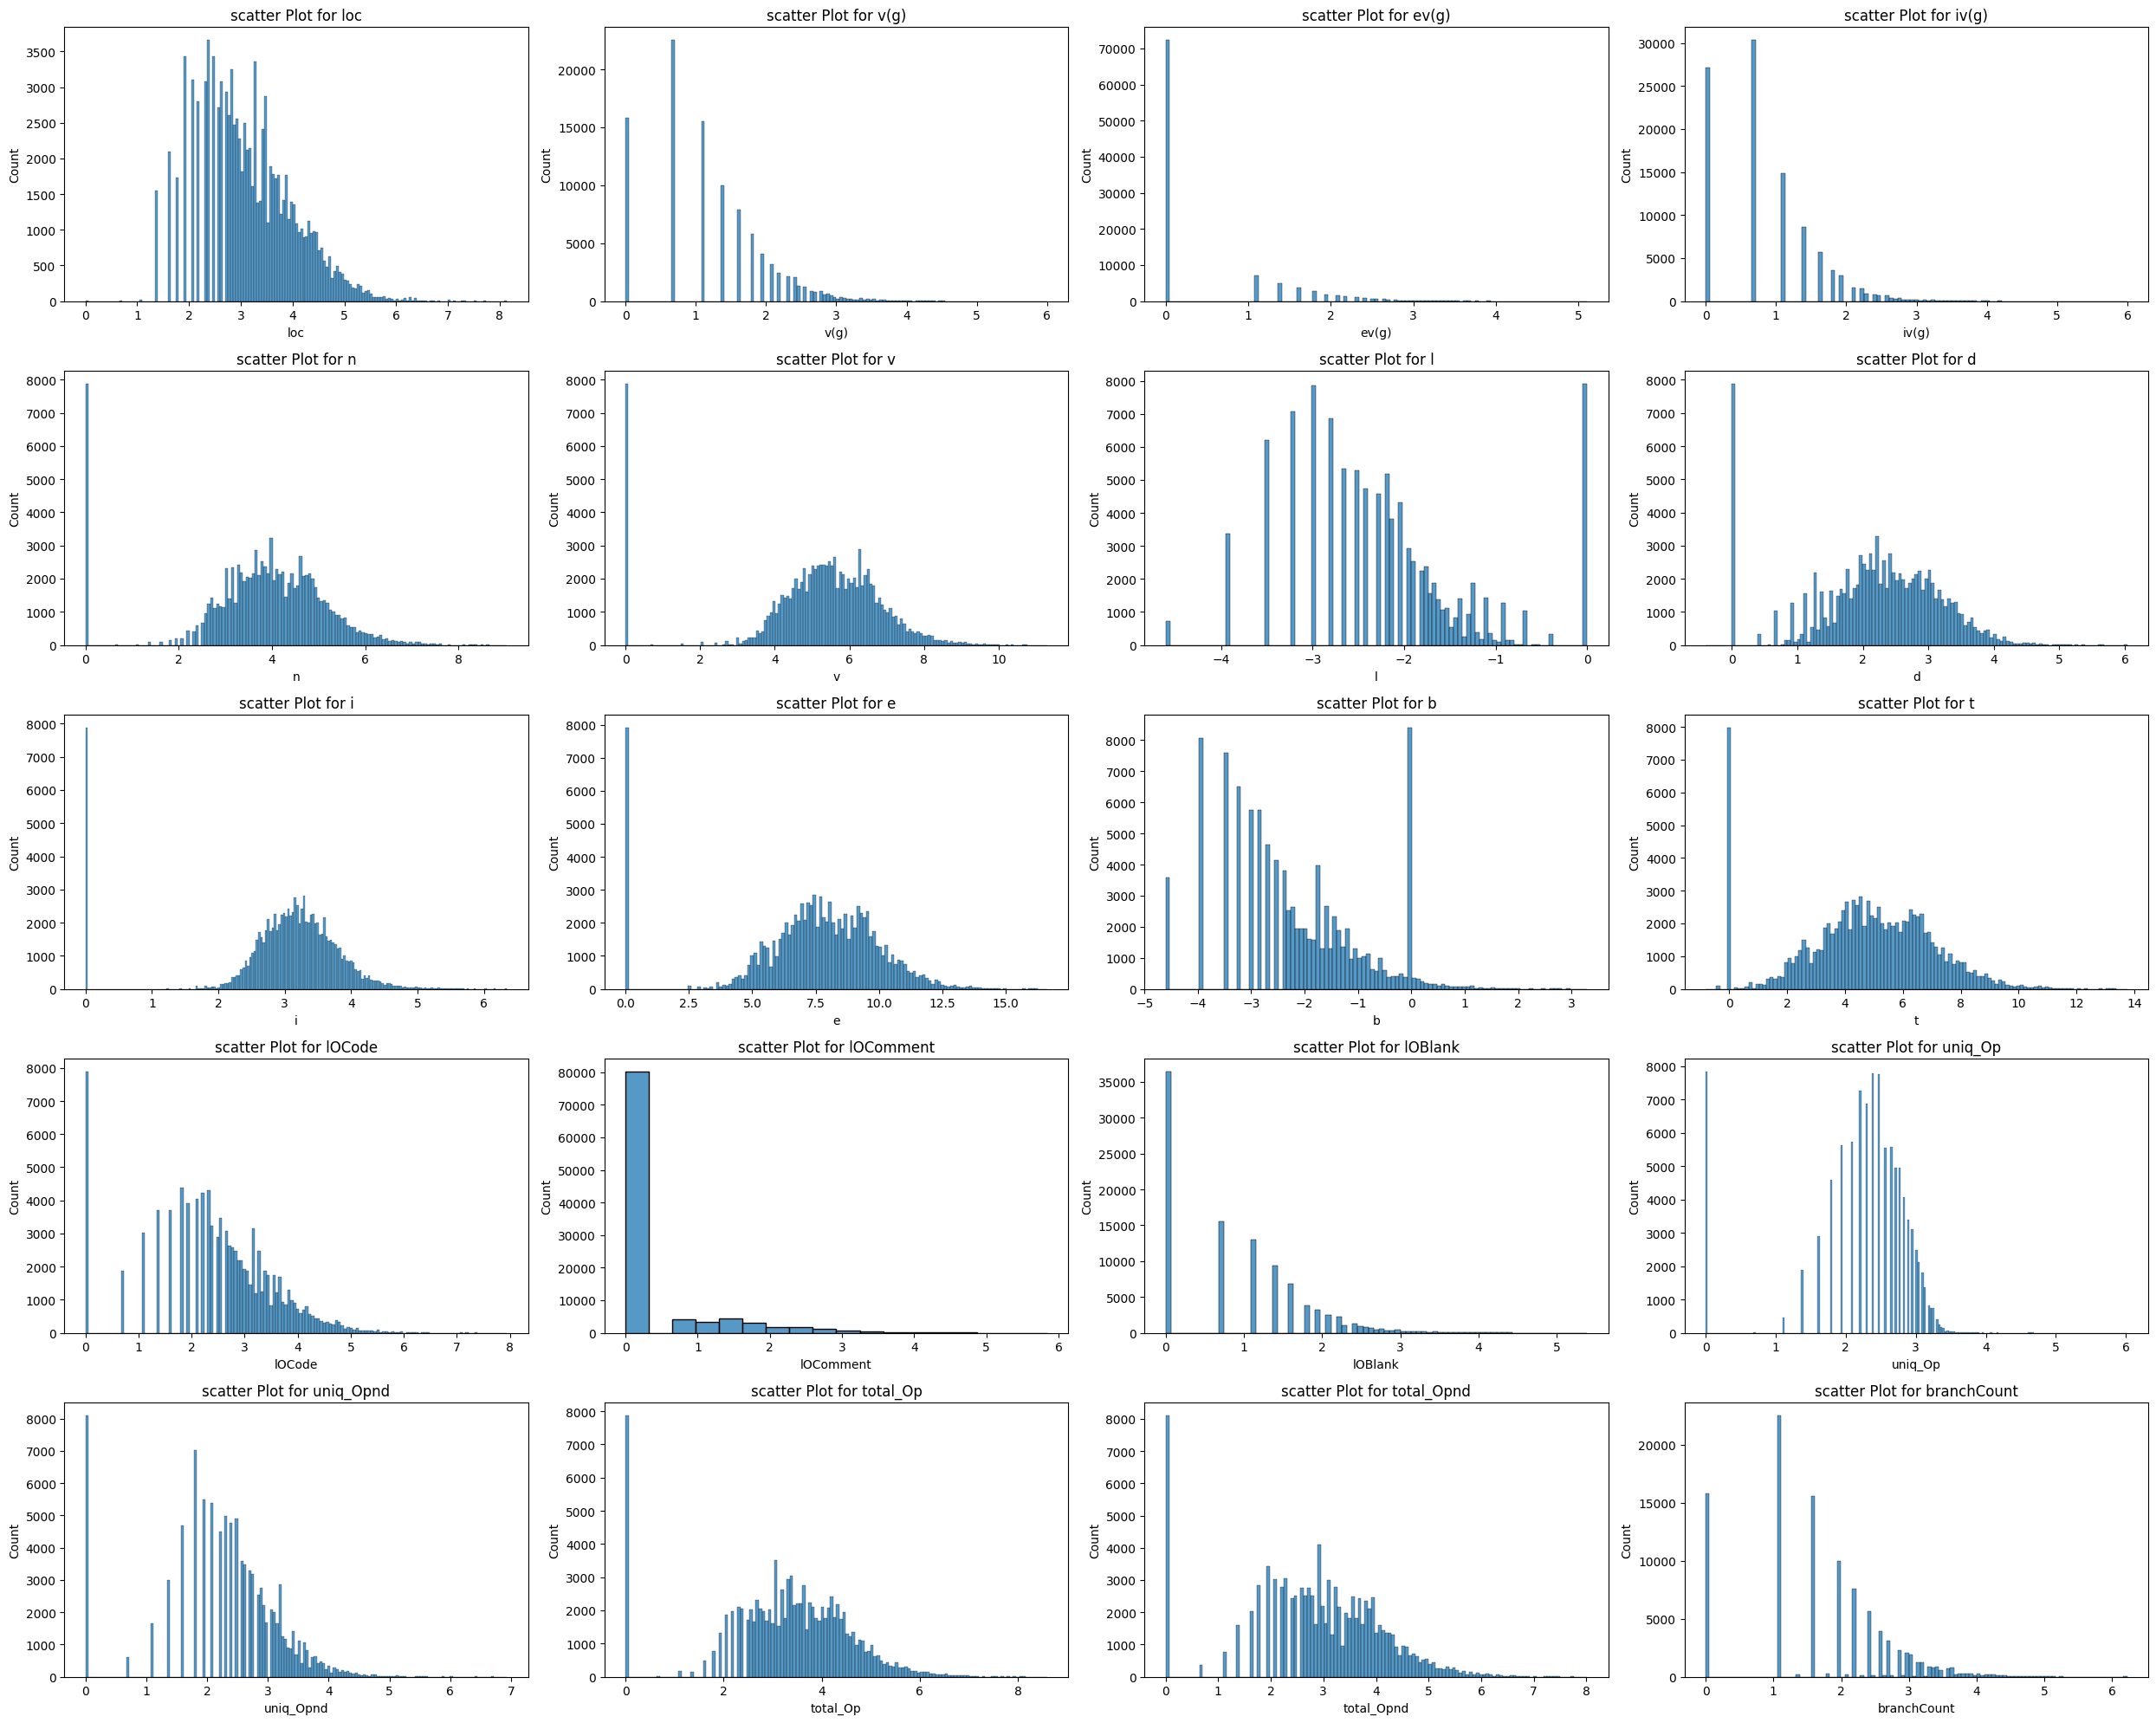

In [9]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
# Flatten the axes array for easier iteration
axes = axes.flatten()
for i, col in enumerate(X_log.columns):
    #sns.scatterplot(x=y, y=X[col], ax=axes[i])
    sns.histplot(x=X_log[col], ax=axes[i])
    axes[i].set_title(f"scatter Plot for {col}")
plt.tight_layout()
# Show the plots
plt.show()

Much better :)

Now we can study how values distribution inside each column is related to the defect value.

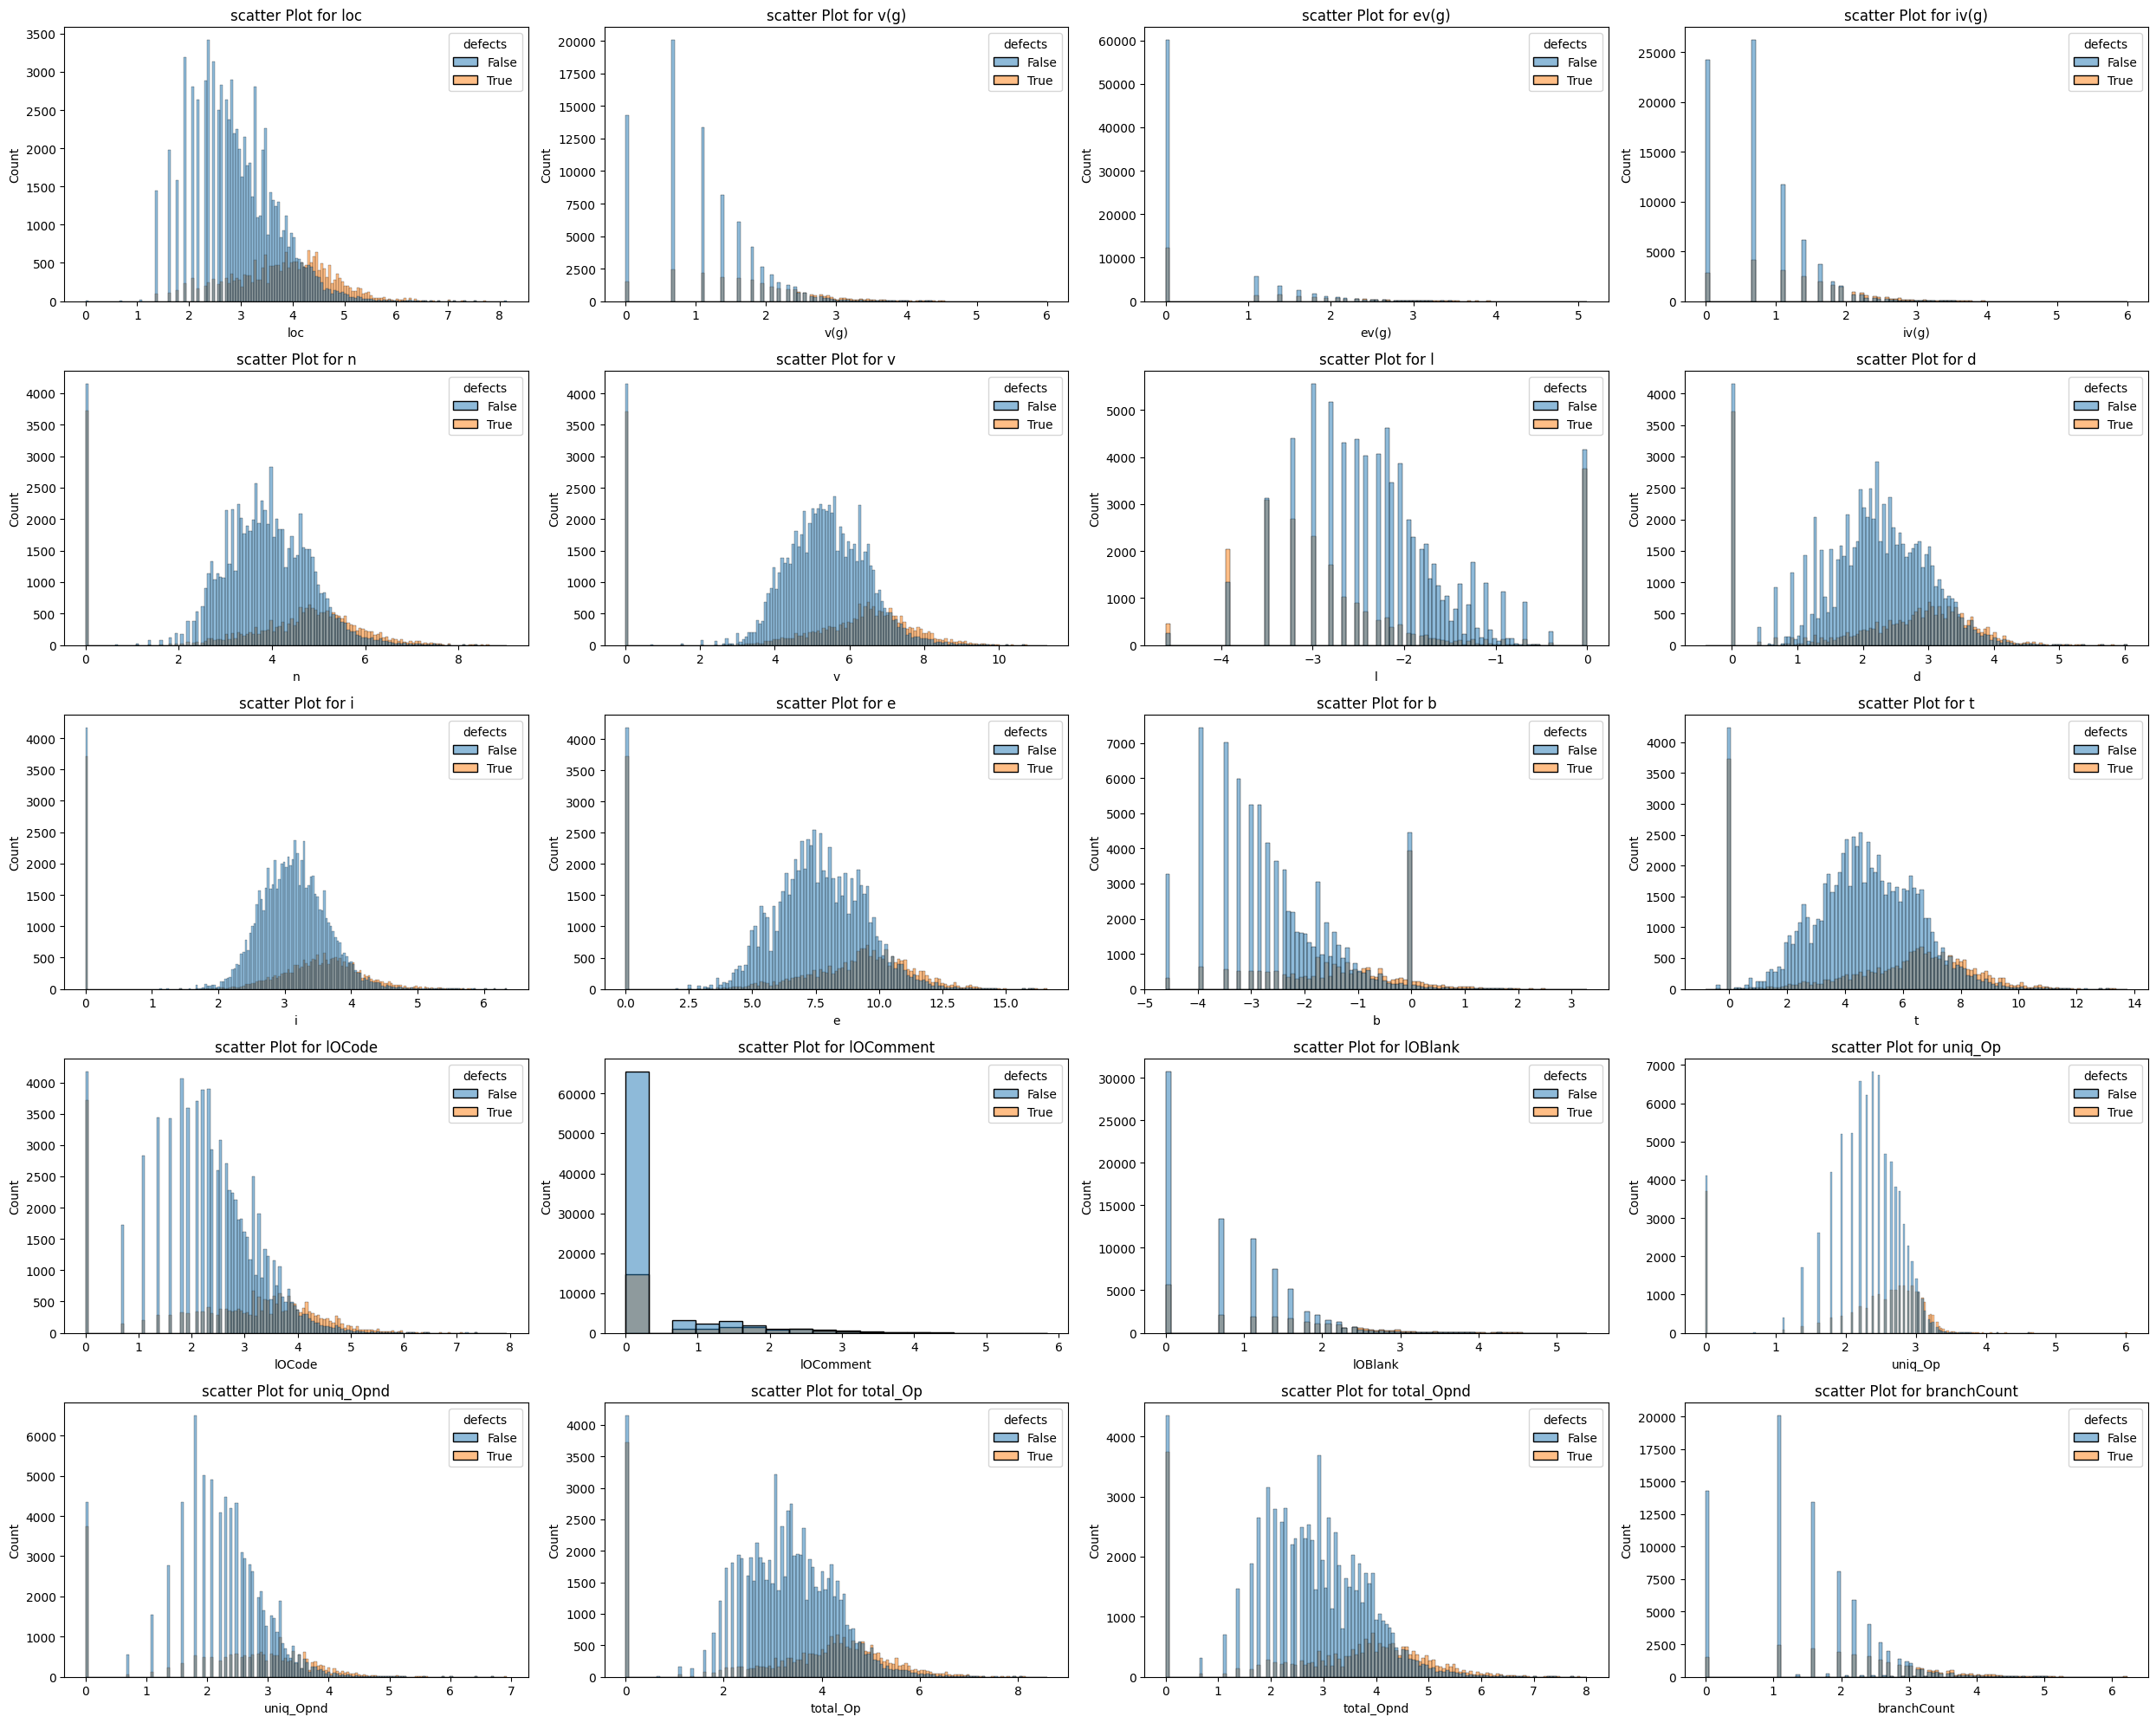

In [10]:
fig, axes = plt.subplots(5, 4, figsize=(25, 20))
# Flatten the axes array for easier iteration
axes = axes.flatten()
for i, col in enumerate(X_log.columns):
    #sns.scatterplot(x=y, y=X[col], ax=axes[i])
    sns.histplot(x=X_log[col], ax=axes[i], hue=y)
    axes[i].set_title(f"scatter Plot for {col}")
plt.tight_layout()
# Show the plots
plt.show()

As we can see, the distributions are slightly different, but overlapping a lot. Ideally, we would like them to be separated in order to make 
it easier for our classifier to predict the outcome given the feature value.

We can try to modify the features to obtain such a separation.

### Polynominial Extraction

In [56]:
degree = 2
poly = PolynomialFeatures(degree=degree, include_bias=False)
poly_features = poly.fit_transform(X)
poly_df = pd.DataFrame(poly_features)
poly_df.head()

,0,1,2,3,4,5,6,7,8,9,...,220,221,222,223,224,225,226,227,228,229
0,22.0,3.0,1.0,2.0,60.0,278.63,0.06,19.56,14.25,5448.79,...,81.0,342.0,198.0,45.0,1444.0,836.0,190.0,484.0,110.0,25.0
1,14.0,2.0,1.0,2.0,32.0,151.27,0.14,7.00,21.11,936.71,...,121.0,198.0,154.0,33.0,324.0,252.0,54.0,196.0,42.0,9.0
2,11.0,2.0,1.0,2.0,45.0,197.65,0.11,8.05,22.76,1754.01,...,121.0,308.0,187.0,33.0,784.0,476.0,84.0,289.0,51.0,9.0
3,8.0,1.0,1.0,1.0,23.0,94.01,0.19,5.25,17.86,473.66,...,36.0,96.0,42.0,6.0,256.0,112.0,16.0,49.0,7.0,1.0
4,11.0,2.0,1.0,2.0,17.0,60.94,0.18,5.63,12.44,365.67,...,36.0,60.0,60.0,18.0,100.0,100.0,30.0,100.0,30.0,9.0


As we can see, we end up with 230 columns, and we only used a degree 2. We don't want to keep all these columns, as it might be just too much 
information to the model. So we can reuse our mutual information computations, and select for example the top 20 new features.

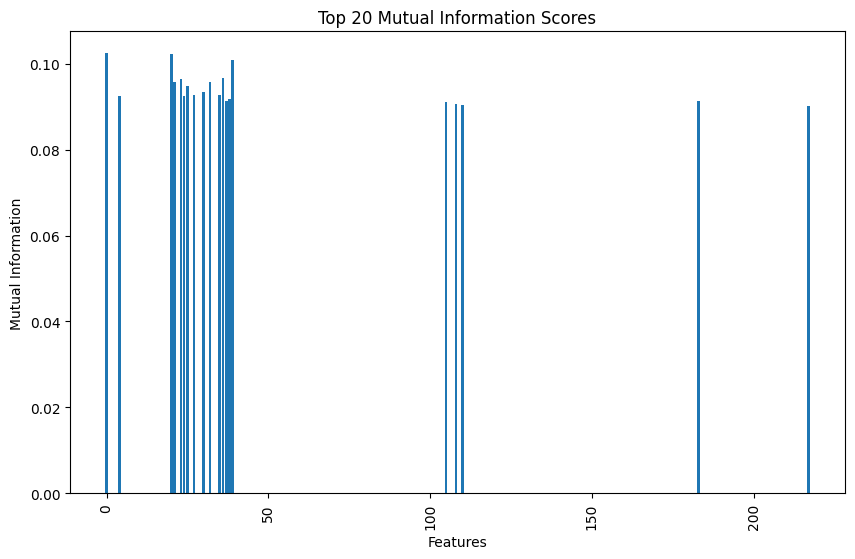

,0,4,20,21,23,24,25,27,30,32,35,36,37,38,39,105,108,110,183,217
0,22.0,60.0,484.0,66.0,44.0,1320.0,6129.86,430.32,1.98,374.0,352.0,198.0,836.0,484.0,110.0,960.0,1320.0,77634.6769,1.98,608.0
1,14.0,32.0,196.0,28.0,28.0,448.0,2117.78,98.00,0.70,154.0,154.0,154.0,252.0,196.0,42.0,352.0,448.0,22882.6129,0.70,198.0
2,11.0,45.0,121.0,22.0,22.0,495.0,2174.15,88.55,0.77,88.0,132.0,121.0,308.0,187.0,33.0,540.0,765.0,39065.5225,1.19,336.0
3,8.0,23.0,64.0,8.0,8.0,184.0,752.08,42.00,0.24,32.0,64.0,48.0,128.0,56.0,8.0,184.0,161.0,8837.8801,0.21,128.0
4,11.0,17.0,121.0,22.0,22.0,187.0,670.34,61.93,0.22,77.0,77.0,66.0,110.0,110.0,33.0,119.0,170.0,3713.6836,0.20,70.0


In [57]:
num_features_to_keep = 20

# Select the top K features using mutual information
selector = SelectKBest(mutual_info_regression, k=num_features_to_keep)
selected_features = selector.fit_transform(poly_df, y)

# Get the indices of the selected features
selected_feature_indices = selector.get_support(indices=True)

# Filter the original DataFrame to keep only the selected features
selected_poly_features = poly_df.iloc[:, selected_feature_indices]
selected_poly_features.head()

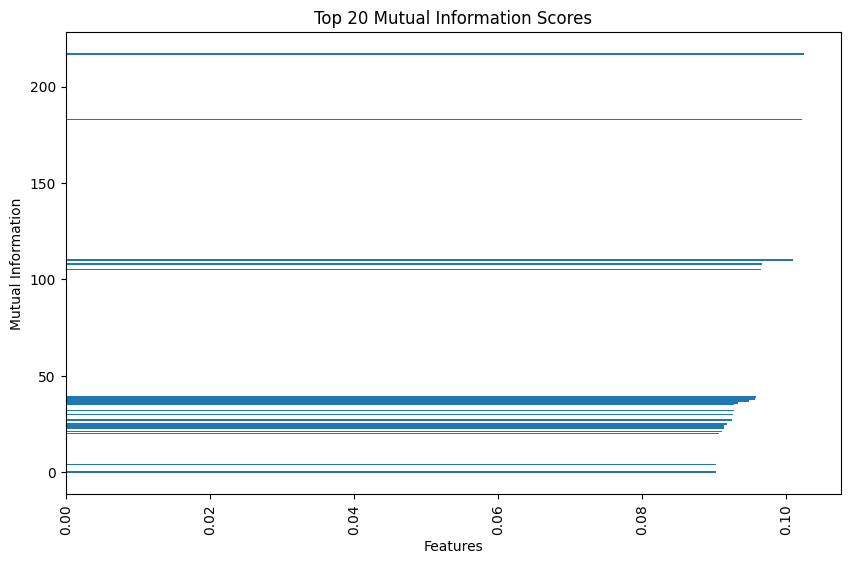

In [67]:
mi_scores = selector.scores_

# Get the feature names
feature_names = poly_df.columns

# Create a DataFrame to store the mutual information scores
mi_scores_df = pd.DataFrame({'Feature': feature_names, 'Mutual Information': mi_scores})
mi_scores_df = mi_scores_df.sort_values(by='Mutual Information', ascending=False)

# Plot the mutual information scores
plt.figure(figsize=(10, 6))
plt.barh(mi_scores_df['Feature'][:num_features_to_keep].sort_values(), mi_scores_df['Mutual Information'][:num_features_to_keep].sort_values())
plt.xticks(rotation=90)
plt.xlabel('Features')
plt.ylabel('Mutual Information')
plt.title('Top 20 Mutual Information Scores')
plt.show()

In [53]:
# fig, axes = plt.subplots(5, 4, figsize=(25, 20))
# # Flatten the axes array for easier iteration
# axes = axes.flatten()
# for i, col in enumerate([0,12,20,21,23,24,25]):
#     #sns.scatterplot(x=y, y=X[col], ax=axes[i])
#     sns.histplot(x=selected_poly_features[col], ax=axes[i], hue=y)
#     axes[i].set_title(f"scatter Plot for {col}")
# plt.tight_layout()
# # Show the plots
# plt.show()

KeyboardInterrupt: 

In [37]:
# we also apply this transformation to X_test_log
# Apply polynomial feature expansion to X_test
poly_features_test = poly.transform(X_test)

# Convert the result back to a DataFrame for easy visualization
poly_df_test = pd.DataFrame(poly_features_test)

# Filter the polynomial features to keep only the selected features
selected_poly_features_test = poly_df_test.iloc[:, selected_feature_indices]
selected_poly_features_test.head()

,0,12,20,21,23,24,25,28,30,32,...,106,108,117,123,180,181,190,197,198,225
0,33.0,30.0,1089.0,165.0,132.0,4752.0,27219.06,991.65,8.91,990.0,...,3312.0,8208.0,24744.60,47014.74,5.67,6.21,28924.80,630.0,690.0,4959.0
1,27.0,23.0,729.0,216.0,54.0,3375.0,17448.48,734.94,5.94,621.0,...,2375.0,6125.0,14863.52,31665.76,3.96,4.18,15287.02,414.0,437.0,3430.0
2,130.0,99.0,16900.0,1430.0,1300.0,70850.0,498082.00,8602.10,166.40,12870.0,...,28885.0,132980.0,379308.60,934861.60,33.28,67.84,342027.02,2574.0,5247.0,81252.0
3,65.0,45.0,4225.0,455.0,455.0,10140.0,55621.15,3242.85,18.85,2925.0,...,4056.0,9360.0,38506.95,51342.60,4.35,7.54,23306.92,675.0,1170.0,5280.0
4,22.0,16.0,484.0,66.0,66.0,1144.0,5245.24,587.40,1.76,352.0,...,780.0,1248.0,3814.72,5722.08,0.96,1.20,2187.00,192.0,240.0,720.0


## Model 

I will first try some XGBoost model and see how it performs.

Work coming after will be based on features selection/engineering

In [38]:
#X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(selected_poly_features, y, test_size=0.2, random_state=42)

### Model training

- We use "tree_method='gpu_hist'" in order to use the GPU for training.
- We also use the auc evaluation metric, as it's the metric used for the competition, so we want to maximise this one

### Comment about 'auc' metric

It seems like using the auc metric yiels to overfitting and always predicting defect values close to 0. This yield bad results, 
often with accuracy around 0.65, far away from our previous scores.

In [27]:
from sklearn.metrics import accuracy_score
import optuna
def objective_xg(trial):
    """Define the objective function"""

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        #'max_depth': trial.suggest_int('max_depth', 1, 30),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        #'learning_rate': trial.suggest_loguniform('learning_rate', 0.001, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 700),
        #'n_estimators': trial.suggest_int('n_estimators', 100, 2000),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 0.5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        #'eval_metric': 'auc',
        'use_label_encoder': False,
        #'objective':'binary:logistic'
    }
    #model_xgb = XGBClassifier(**params, tree_method='gpu_hist')
    model_xgb = XGBClassifier(**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_val)
    #y_pred = model_xgb.predict_proba(X_val)[:, 1]
    return accuracy_score(y_val,y_pred)
    #return roc_auc_score(y_val,y_pred)

### Classic CGBoost classifier

In [40]:
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score
import optuna

def objective_xg(trial):
    """Define the objective function"""

    params = {
        'booster': trial.suggest_categorical('booster', ['gbtree']),
        'max_depth': trial.suggest_int('max_depth', 1, 10),
        'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.05),
        'n_estimators': trial.suggest_int('n_estimators', 300, 700),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'gamma': trial.suggest_loguniform('gamma', 1e-8, 1.0),
        'subsample': trial.suggest_loguniform('subsample', 0.1, 1.0),
        'colsample_bytree': trial.suggest_loguniform('colsample_bytree', 0.01, 0.5),
        'reg_alpha': trial.suggest_loguniform('reg_alpha', 1e-8, 1.0),
        'reg_lambda': trial.suggest_loguniform('reg_lambda', 1e-8, 1.0),
        'eval_metric': 'mlogloss',
        'use_label_encoder': False
    }
    #model_xgb = XGBClassifier(**params, tree_method='gpu_hist')
    model_xgb = XGBClassifier(**params)
    model_xgb.fit(X_train, y_train)
    y_pred = model_xgb.predict(X_val)
    return accuracy_score(y_val,y_pred)

In [41]:
study_xgb = optuna.create_study(direction='maximize')
optuna.logging.set_verbosity(optuna.logging.WARNING)
study_xgb.optimize(objective_xg, n_trials=50,show_progress_bar=True)

Best trial: 21. Best value: 0.816194: 100%|██████████| 50/50 [00:46<00:00,  1.08it/s]


In [42]:
#xgb = XGBClassifier(**study_xgb.best_params, tree_method='gpu_hist')
xgb = XGBClassifier(**study_xgb.best_params)
xgb.fit(X_train, y_train)

#y_prob = xgb.predict_proba(X_test)[:, 1]
y_prob = xgb.predict_proba(selected_poly_features_test)[:, 1]
#submission = pd.DataFrame({'id': X_test.index, 'defects': y_prob})
submission = pd.DataFrame({'id': X_test.index, 'defects': y_prob})
#submission.to_csv('data/submission.csv', index=False)
submission.to_csv('data/submission_xbg_feature_eng.csv.csv', index=False)
submission.head()

,id,defects
0,101763,0.250138
1,101764,0.209252
2,101765,0.642500
3,101766,0.480648
4,101767,0.137326


Adding the polynomial extraction didn't yield better results, but I will invistigate this in detail and provide an more in-depth analysis

### Some results:

Polynomial extraction...

degree 2:

- top 10 features: score = 0.816194 (local), 0.78453 (test)
- top 20 features: score = 0.815654 (local), 0.78528 (test)
- top 30 features: score = TODO
- top 40 features: score = TODO


degree 3:
TODO


### CatBoost classifier

In [19]:
# import optuna
# def objective_cat(trial):
#     """Define the objective function"""

#     params = {
#         "iterations" : trial.suggest_int("iterations", 100, 1000),
#         'learning_rate': trial.suggest_float('learning_rate', 0.01, 1.0),
#         "depth" : trial.suggest_int("depth", 1, 10),
#         "l2_leaf_reg" : trial.suggest_float("l2_leaf_reg", 1e-8, 100.0, log=True),
#         "bootstrap_type" : trial.suggest_categorical("bootstrap_type", ["Bayesian"]),
#         "random_strength" : trial.suggest_float("random_strength", 1e-8, 10.0, log=True),
#         "bagging_temperature" : trial.suggest_float("bagging_temperature", 0.0, 10.0),
#         "od_type" : trial.suggest_categorical("od_type", ["IncToDec", "Iter"]),
#         "od_wait" : trial.suggest_int("od_wait", 10, 50),
#         "verbose" : False
#     }


#     model_cat = CatBoostClassifier(**params)
#     model_cat.fit(X_train, y_train)
#     y_pred = model_cat.predict(X_val)
#     # convert into binary values
#     y_pred = [0 if x == 'False' else 1 for x in y_pred]
#     return accuracy_score(y_val,y_pred)

In [20]:
# study_cat = optuna.create_study(direction='maximize')
# optuna.logging.set_verbosity(optuna.logging.WARNING)
# study_cat.optimize(objective_cat, n_trials=50,show_progress_bar=True)

  0%|          | 0/50 [00:02<?, ?it/s]

[W 2023-10-18 15:13:53,771] Trial 0 failed with parameters: {'iterations': 265, 'learning_rate': 0.38761672281281057, 'depth': 8, 'l2_leaf_reg': 0.0001613703970043777, 'bootstrap_type': 'Bayesian', 'random_strength': 4.717036940598185, 'bagging_temperature': 8.202219496694838, 'od_type': 'IncToDec', 'od_wait': 33} because of the following error: NameError("name 'X_val' is not defined").
Traceback (most recent call last):
  File "/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/optuna/study/_optimize.py", line 200, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/var/folders/cr/_dkxlvn52nl_jhzt0lz5wrhh0000gn/T/ipykernel_7512/152020420.py", line 21, in objective_cat
    y_pred = model_cat.predict(X_val)
                               ^^^^^
NameError: name 'X_val' is not defined
[W 2023-10-18 15:13:53,772] Trial 0 failed with value None.


NameError: name 'X_val' is not defined

In [45]:
# cat = CatBoostClassifier(**study_cat.best_params, verbose=False)
# cat.fit(X_train, y_train)
# y_pred = cat.predict(X_val)
# y_pred = [0 if x == 'False' else 1 for x in y_pred]
# print('Accuracy: ', accuracy_score(y_val, y_pred))

In [46]:
# y_prob = cat.predict_proba(selected_poly_features_test)[:, 1]
# submission = pd.DataFrame({'id': X_test.index, 'defects': y_prob})
# submission.to_csv('data/submission_cb_poly_exp.csv', index=False)
# #submission.to_csv('submission.csv', index=False)
# submission.head()

## Support vector machines

In [47]:
# svm_classifier = SVC()

# # Train the SVM classifier
# svm_classifier.fit(X_train, y_train)

# # Predict using the test set
# y_pred = svm_classifier.predict(X_val)

# # Evaluate the model
# accuracy = accuracy_score(y_val, y_pred)
# classification_rep = classification_report(y_val, y_pred)

# print(f'Accuracy: {accuracy}')
# print(f'Classification Report:\n{classification_rep}')

### Cross Validation Training

In [1]:
from sklearn.model_selection import cross_val_score

In [31]:
def train_model(model, X, y):
    kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)
    print("Training model:", model.__class__.__name__)
    scores = cross_val_score(model,
                        X,
                        y,
                        scoring = 'roc_auc',
                        cv = kf,
                        n_jobs = -1)
    print(f'{model.__class__.__name__} auroc score: {scores.mean()}')

In [38]:
# define models we will use:
cat = CatBoostClassifier(verbose=False)
xgb = XGBClassifier(verbose=False)
lgbm = LGBMClassifier(verbose=0)
hist = HistGradientBoostingClassifier()


In [35]:
for model in [cat, xgb, lgbm, hist]:
    train_model(model, X, y)

Training model: CatBoostClassifier
CatBoostClassifier auroc score: 0.7905228478264759
Training model: XGBClassifier


/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) in

XGBClassifier auroc score: 0.7857600451641625
Training model: LGBMClassifier
LGBMClassifier auroc score: 0.7918485545027518


In [57]:
eclf = VotingClassifier(
     estimators=[('lgbm', lgbm), ('cat', cat), ('hist', hist), ('xgb', xgb)],
     #estimators=[('lgbm', lgbm), ('cat', cat), ('hist', hist)],
     voting='soft')

In [62]:
train_model(eclf, X, y)

Training model: VotingClassifier


/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

VotingClassifier auroc score: 0.7921628009651999


/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

In [63]:
eclf.fit(X, y)
submission = pd.DataFrame({'id': X_test.index, 'defects': pd.Series(eclf.predict_proba(X_test)[:, 1])})

In [56]:
submission.to_csv('data/submission_voting_classifier.csv', index=False)

In [66]:
import optuna

kf = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

# Define objective functions for each model
def objective_lgbm(trial):
    params = {
        'num_leaves': trial.suggest_int('num_leaves', 2, 100),
        'min_child_samples': trial.suggest_int('min_child_samples', 2, 100),
        # Add other hyperparameters as needed
    }
    model = LGBMClassifier(**params, verbose=0)
    return cross_val_score(model, X, y, scoring='roc_auc', cv=kf, n_jobs=-1).mean()

def objective_cat(trial):
    params = {
        'iterations': trial.suggest_int('iterations', 100, 1000),
        'depth': trial.suggest_int('depth', 1, 10),
        # Add other hyperparameters as needed
    }
    model = CatBoostClassifier(**params, verbose=False)
    return cross_val_score(model, X, y, scoring='roc_auc', cv=kf, n_jobs=-1).mean()

def objective_xgb(trial):
    params = {
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        'learning_rate': trial.suggest_float('learning_rate', 0.001, 0.1),
        # Add other hyperparameters as needed
    }
    model = XGBClassifier(**params, verbose=False)
    return cross_val_score(model, X, y, scoring='roc_auc', cv=kf, n_jobs=-1).mean()

def objective_hist(trial):
    params = {
        'max_iter': trial.suggest_int('max_iter', 100, 1000),
        'max_depth': trial.suggest_int('max_depth', 2, 20),
        # Add other hyperparameters as needed
    }
    model = HistGradientBoostingClassifier(**params)
    return cross_val_score(model, X, y, scoring='roc_auc', cv=kf, n_jobs=-1).mean()

# Define a dictionary to map models to their objective functions
objective_functions = {
    'lgbm': objective_lgbm,
    'cat': objective_cat,
    'xgb': objective_xgb,
    'hist': objective_hist,
}

# Use Optuna to find the best hyperparameters for each model
for model_name, objective_func in objective_functions.items():
    study = optuna.create_study(direction='maximize')
    study.optimize(objective_func, n_trials=5)
    best_params = study.best_params

    # Print the best hyperparameters for each model
    print(f'Best hyperparameters for {model_name}:', best_params)

    # Apply the best hyperparameters to the models
    if model_name == 'lgbm':
        lgbm.set_params(**best_params)
    elif model_name == 'cat':
        cat.set_params(**best_params)
    elif model_name == 'xgb':
        xgb.set_params(**best_params)
    elif model_name == 'hist':
        hist.set_params(**best_params)

# Train the models with tuned hyperparameters
train_model(eclf, X, y)


Best hyperparameters for lgbm: {'num_leaves': 47, 'min_child_samples': 29}
Best hyperparameters for cat: {'iterations': 566, 'depth': 7}


/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_cate

Best hyperparameters for xgb: {'max_depth': 5, 'learning_rate': 0.006472734104959703}
Best hyperparameters for hist: {'max_iter': 425, 'max_depth': 7}
Training model: VotingClassifier


/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

VotingClassifier auroc score: 0.7923289264176869


/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:335: FutureWarning: is_sparse is deprecated and will be removed in a future version. Check `isinstance(dtype, pd.SparseDtype)` instead.
  if is_sparse(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:338: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  is_categorical_dtype(dtype) or is_pa_ext_categorical_dtype(dtype)
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:384: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if is_categorical_dtype(dtype):
/Users/douglas/miniconda3/envs/kaggle/lib/python3.11/site-packages/xgboost/data.py:359: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, C

In [68]:
submission = pd.DataFrame({'id': X_test.index, 'defects': pd.Series(eclf.predict_proba(X_test)[:, 1])})
submission.to_csv('data/submission_voting_classifier_0.csv', index=False)